# Fitting a first model

On this notebook, I am creating a criteria of sucess for each restaurant of Zomato. This criteria will be the target from our test model.
Also I will analyse the location and cuisine of restaurant in function of all demographic and financial data to then fit my first model.

In [1]:
import requests
from bs4 import BeautifulSoup
import urllib2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import create_engine


In [2]:
# loading the data
engine=create_engine('postgresql://localhost:5432/capstone')
conn=engine.connect()

In [3]:
%load_ext sql 

In [4]:

%%sql postgresql://localhost:5432/capstone
        
select * from zomato_2 limit 2;

2 rows affected.


index,id,name,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude,group_cuisine,London zone,district_code,District,area_cover,restaurant_nearby,cluster
0,6111707,Barracuda,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,-0.300338,cafe,3.0,W5,Ealing,0.0168458275746,2,2
1,6102909,Starbucks,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,-0.305182,cafe,3.0,W5,Ealing,0.0331196749246,1,-1


In [5]:

%%sql

select * from "Dem_Fin_1" limit 2;

2 rows affected.


index,Area name,GLA Population Estimate 2015,GLA Household Estimate 2015,Inland Area -hec,Population density - Hec-2015,"Average Age, 2015",Employment rate - 2014,Unemployment rate-2014,Gross Annual Pay-2014,Modelled Household median income estimates 2012/13,Number of jobs by workplace-2013,"Jobs Density, 2013",Two-year business survival rates-2011/2015,"Median House Price, 2014","Average Public Transport Accessibility score, 2014",Perc. People aged 17+ with diabetes
0,City of London,8200,4700.0,290.4,28.2,41.9,80.2,4.2,56967.4390244,99390.0,460700.0,81.0,63.8,765000,7.9,2.6
1,Barking and Dagenham,203600,74010.0,3610.8,56.4,32.9,63.6,11.5,27252.0,34080.0,54300.0,0.0,73.0,215000,3.0,7.3


## Restaurant success categorisation

We now have to categorise the health of a business so that our model predict the best location at the moment for a type of food.
How to categorise?
Well, we could look at the profit margin: Profit = Revenue - Cost.
Of course, I don’t have all parameters to calculate the exact profit but as we only want to compare restaurants to each other, we can consider only the parameter relative to each restaurant. Which means, electricity bill, wages, etc are actually constant through all restaurant but other such as revenue , cost of ingredients, rental expenses

We are the reducing the problem to:

**Profit_reduced ≈ Revenue - [ Cost_ing + Cost_rent]**


__Revenue:__

Keeping with consideration because, as a recall we want to categorise restaurant, the revenue can be considered proportional to the number of vote. Indeed, the number of votes being proportional to the attendance level.
Although we are not taking into consideration the year of service, we are fitting a model on our actual static data. Thus, after the model being shaped, it could be scaled to the weekly/monthly evolution of the number of votes

**Revenue ≈ K1 \* (Number of votes) \* cost_for_two **

_On average 1 vote for 2 persons_

__Cost ingredients:__

Ingredient will be chosen in function of the cuisine and quality you want to propose. Although, it common that the ingredient should represent between 25% to 45% of the price propose to the customer and the quality is linked to the price range category. In other words, with the data we have, we can rewrite the Cost_ing as such:

**Cost_ing ≈ F(cuisine, quality) ≈ F(cuisine, cost_for_2, price_range) ≈  Average(cuisine, 35%*cost_for_two ,price_range)*(Number of votes) **

__Cost of the place:__

I am here presuming that the square meters for each restaurant are more or less the same as well as all of them having rental,mortgage,.., expenses. Of course, this is not totally the case but I think close to the reality.

As I have got the median house price in London, accommodation expenses will be proportional to the rental expenses from where the district has the average minimum house price multiply by a factor. The factor being the median house price of the District divided by a minimum median house price.

**Revenue ≈ K2* (Median_house_price_district / Minimum(median_house_price_all_district) )**


__In a nutshell:__


**Profit_reduced ≈ K1* (Number of votes)*cost_for_two**
	**- Average(cuisine, 35%\*cost_for_two,price_range)\*(Number of votes) ** 
	**- K2* (Median_house_price_district / Minimum(median_house_price_all_district))**
    
The aim of this formula is not to get the exact profit, because probably it contains some inconsistencies. Moreover, as the cost of the place is in a totaly different scale, it makes no sense to retrieve it. 

That why, we will use the coefficient Median_house_price_district / Minimum(median_house_price_all_district) as a tuner. Indeed, if two restaurat have the same cuisine and selling price, to equalize their profit, or they have the same accomodation charges or the first restaurant have a number of customer proportional to rent of the other.

We would then get the following formula:

**Profit_reduced ≈ (K1* (Number of votes)*cost_for_two**
	**- Average(cuisine, 35%\*cost_for_two,price_range)\*(Number of votes))/Location\_coeff ** 
    
Location\_coeff=Median\_house\_price\_district / Minimum(median\_house\_price\_all\_district) 

Consequently, after scaling each feature of the formula, we would be able to find cluster of restaurant taking into account those 3 features (revenue and costs). The cluster created will permit to categorise the restaurant.

I will select only restaurants with votes to fit and train my model.

In [6]:
#calculating revenue_reduced.

%sql select "id","votes"*"average_cost_for_two" as Revenue_reduced  from zomato_2 where "votes" != 0 limit 5;

5 rows affected.


id,revenue_reduced
6111707,175.0
6102909,60.0
6125893,50.0
6125648,950.0
6117266,675.0


In [7]:
#Calculating unit cost and save it on my PostgreSQL localhost

%sql DROP TABLE IF EXISTS table_unit_cost

%sql CREATE TABLE table_unit_cost as (Select cuisine, price_range, average_cost_unit from\
(select "group_cuisine" as cuisine, "price_range" as price_range \
 ,AVG("average_cost_for_two") as average_cost_unit  \
 from zomato_2 where "votes" != 0 GROUP BY cuisine, price_range) as table_intermediate);                                    

Done.
54 rows affected.


[]

In [8]:
# calculating ingredient expenses for each restaurant
%sql SELECT Z."id", TUC.average_cost_unit*Z."votes" AS cost_ing FROM zomato_2 Z\
    LEFT JOIN table_unit_cost TUC ON TUC.cuisine=Z."group_cuisine" and TUC.price_range=Z."price_range"\
    where "votes" != 0 limit 5;
    

5 rows affected.


id,cost_ing
6111707,159.193548387
6102909,56.2065217391
6125893,42.7380952381
6125648,827.058823529
6117266,827.419354839


In [9]:
# calculating coefficient for accomodation expenses compare to minimum median houst price area

minimum_house_price=int(conn.execute('SELECT MIN("Median House Price, 2014") from "Dem_Fin_1";').fetchall()[0][0])


house_price=pd.read_sql('SELECT "Area name" as District , "Median House Price, 2014" as location_coeff \
from "Dem_Fin_1" ;', con=conn)

house_price["location_coeff"]=(house_price["location_coeff"]/minimum_house_price)
house_price.head()


,district,location_coeff
0,City of London,3.558140
1,Barking and Dagenham,1.000000
2,Barnet,1.860465
3,Bexley,1.162791
4,Brent,1.790698


In [10]:
# grouping everything into zomato table

df_zomato=pd.read_sql("select * from zomato_2 where votes != 0;",con=conn)
del df_zomato["index"]


revenue_red=pd.read_sql('select "id","votes"*"average_cost_for_two" as Revenue_reduced  from zomato_2 where "votes" != 0;',con=conn)

cost_ing=pd.read_sql('SELECT Z."id", TUC.average_cost_unit*Z."votes" AS cost_ing FROM zomato_2 Z\
    LEFT JOIN table_unit_cost TUC ON TUC.cuisine=Z."group_cuisine" and TUC.price_range=Z."price_range"\
    where "votes" != 0',con=conn)

df_zomato=pd.merge(df_zomato,revenue_red, on="id", how="left")

df_zomato=pd.merge(df_zomato,cost_ing, on="id", how="left")

df_zomato=pd.merge(df_zomato,house_price, left_on="District", right_on="district")

df_zomato["profit_tuned"]=(df_zomato["revenue_reduced"] - 0.35*df_zomato["cost_ing"])/df_zomato["location_coeff"]


del df_zomato["district"]
df_zomato.head()

,id,name,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,...,London zone,district_code,District,area_cover,restaurant_nearby,cluster,revenue_reduced,cost_ing,location_coeff,profit_tuned
0,6111707,Barracuda,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,...,3.0,W5,Ealing,0.016846,2,2,175.0,159.193548,1.804651,66.097128
1,6102909,Starbucks,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,...,3.0,W5,Ealing,0.033120,1,-1,60.0,56.206522,1.804651,22.346544
2,6125893,Ristorante Belvedere,3.0,50.0,0.0,1,London,Ealing,W5 1EE,51.530182,...,3.0,W5,Ealing,5.336550,4,0,50.0,42.738095,1.804651,19.417418
3,6125648,Royal Nawaab,3.0,50.0,3.5,19,London,Greenford,UB6 8DW,51.533616,...,4.0,UB6,Ealing,0.629461,0,-1,950.0,827.058824,1.804651,366.015009
4,6117266,Pizza House,2.0,25.0,3.4,27,London,Ealing,W5 1QX,51.526251,...,4.0,W5,Ealing,1.783806,1,-1,675.0,827.419355,1.804651,213.561066


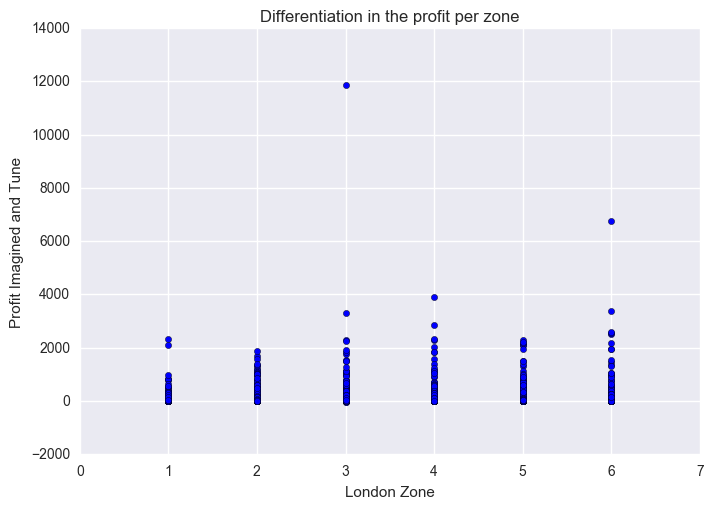

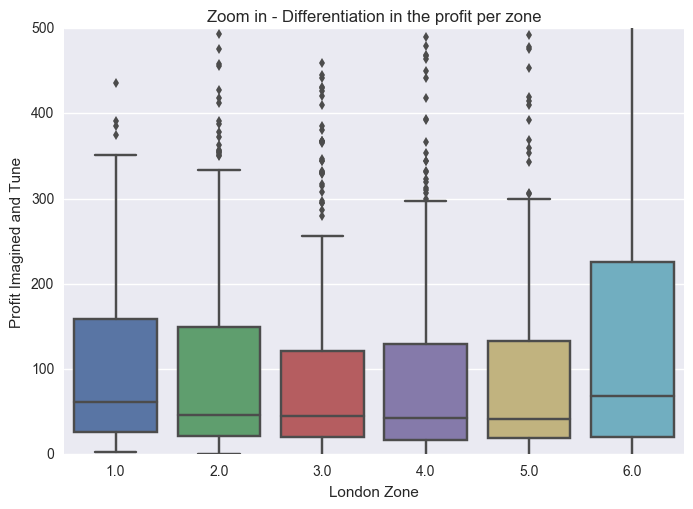

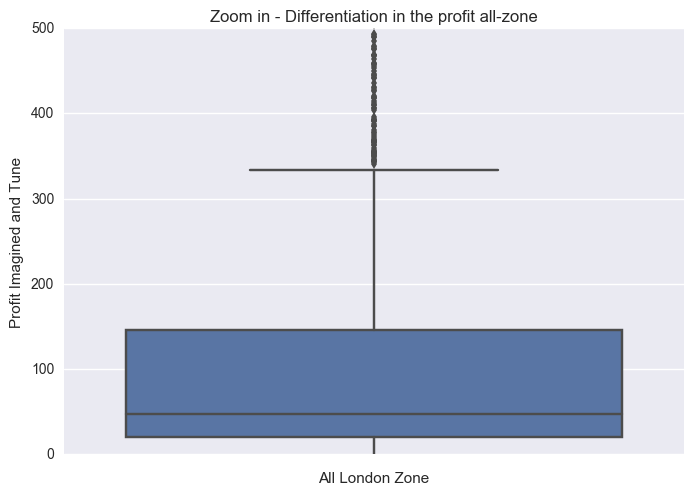

In [11]:
# let's look at the profit per zone

plt.scatter(df_zomato["London zone"],df_zomato["profit_tuned"])
plt.xlabel("London Zone")
plt.ylabel("Profit Imagined and Tune")
plt.title("Differentiation in the profit per zone")
plt.show()

sns.boxplot(df_zomato["London zone"],df_zomato["profit_tuned"])
plt.ylim((0,500))
plt.xlabel("London Zone")
plt.ylabel("Profit Imagined and Tune")
plt.title("Zoom in - Differentiation in the profit per zone")
plt.show()

sns.boxplot(df_zomato["profit_tuned"],orient="v")
plt.ylim((0,500))
plt.xlabel("All London Zone")
plt.ylabel("Profit Imagined and Tune")
plt.title("Zoom in - Differentiation in the profit all-zone")
plt.show()

As we can see, it is possible to have certain degree of success at each London Zone.
I remember that as we don't have all cost and revenue, we can't really talk about success or failure, the work is to compare restaurant between each other and gather them in category of "success". That's why few of them have a negative profit.

I am now creating 5 categories of likelihood of success with their own label:

- Totaly likely : 5
- Very Likely: 4
- Likely: 3
- Few chance: 2
- Very few chance: 1


In [12]:
# Creating category of success

print "-Not very likely chances of success for profit_tuned below %.2f"%df_zomato["profit_tuned"].quantile(0.05)
print "-Few chances of success for profit_tuned between %.2f and %.2f"%\
(df_zomato["profit_tuned"].quantile(0.05),df_zomato["profit_tuned"].quantile(0.3))
print "-Likely to get success for profit_tuned between %.2f and %.2f"%\
(df_zomato["profit_tuned"].quantile(0.3),df_zomato["profit_tuned"].quantile(0.70))
print "-Very Likely to get success for profit_tuned between %.2f and %.2f"%\
(df_zomato["profit_tuned"].quantile(0.70),df_zomato["profit_tuned"].quantile(0.95))
print "-Totaly Likely to get success for profit_tuned above %.2f"%\
(df_zomato["profit_tuned"].quantile(0.95))

def get_category(row):
    category=[1,2,3,4,5,6]
    threshold=[df_zomato["profit_tuned"].quantile(0.05),\
              df_zomato["profit_tuned"].quantile(0.3),\
              df_zomato["profit_tuned"].quantile(0.70),\
              df_zomato["profit_tuned"].quantile(0.95),max(df_zomato["profit_tuned"])]
    check= row <= threshold[0]
    index=0
    while check==False:
        index+=1
        check= row<=threshold[index]
    
    return category[index]
    
 
df_zomato["target"]=df_zomato["profit_tuned"].apply(get_category)


-Not very likely chances of success for profit_tuned below 6.25
-Few chances of success for profit_tuned between 6.25 and 24.13
-Likely to get success for profit_tuned between 24.13 and 113.95
-Very Likely to get success for profit_tuned between 113.95 and 644.28
-Totaly Likely to get success for profit_tuned above 644.28


In [13]:
group_target=df_zomato.groupby(["target","group_cuisine"]).size()

**Below is the distribution by category of success and cuisine**


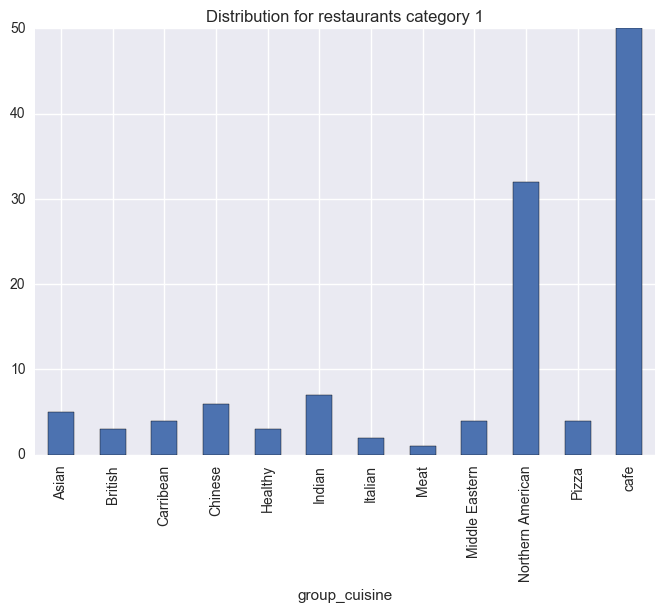

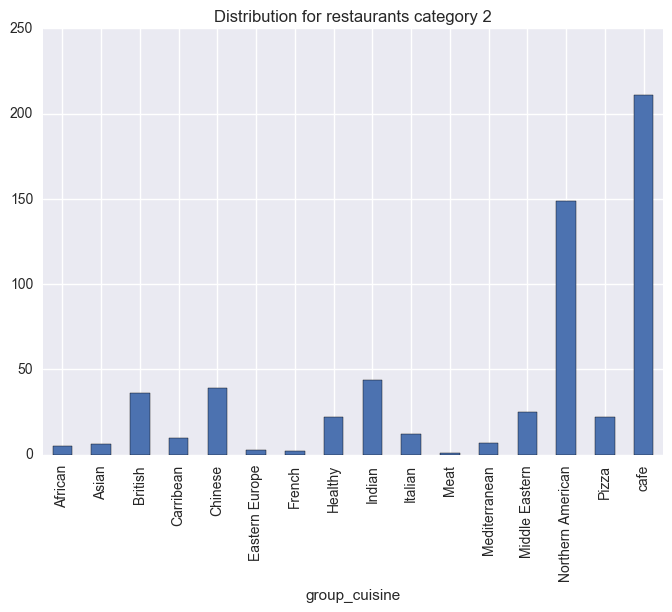

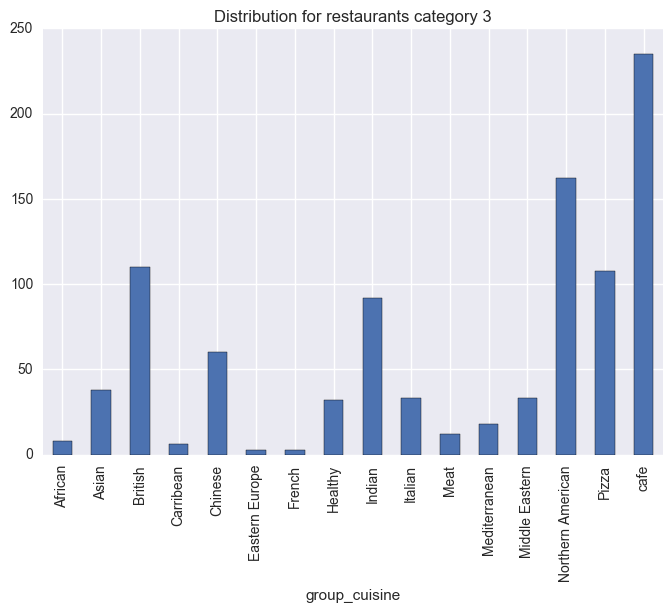

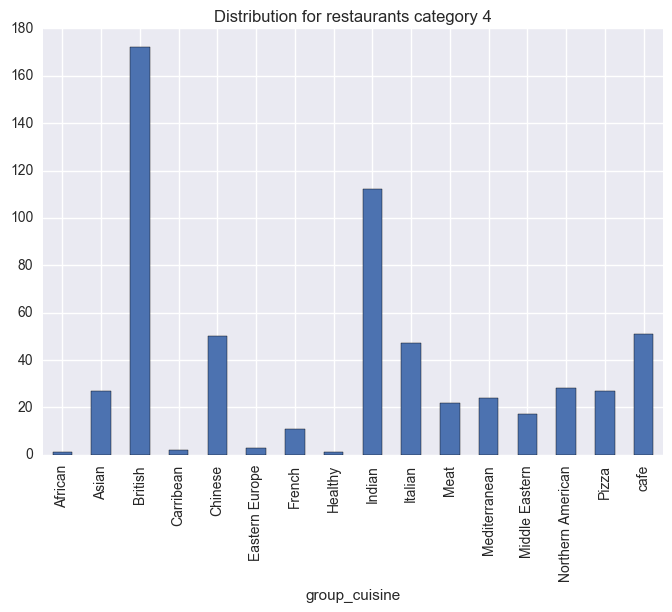

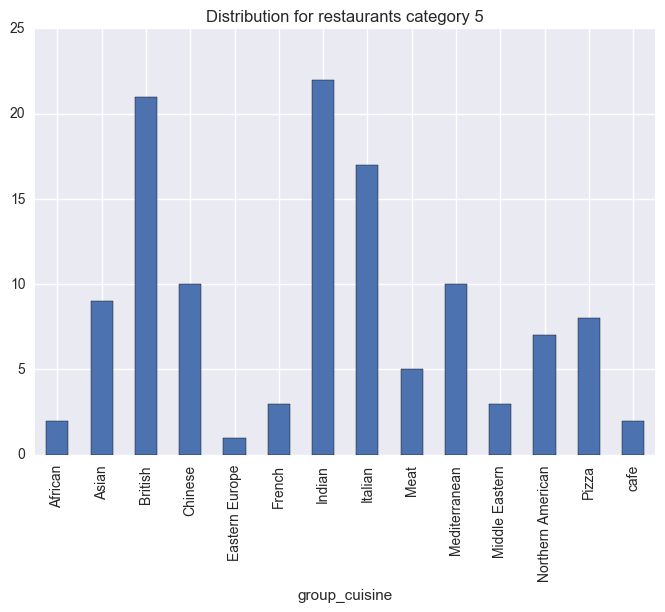

In [14]:
print "**Below is the distribution by category of success and cuisine**"

for i in range(1,6):
    group_target[i].plot(kind="bar")
    plt.title("Distribution for restaurants category %d"%i)
    plt.show()

**Below is the distribution by category of success and price range**


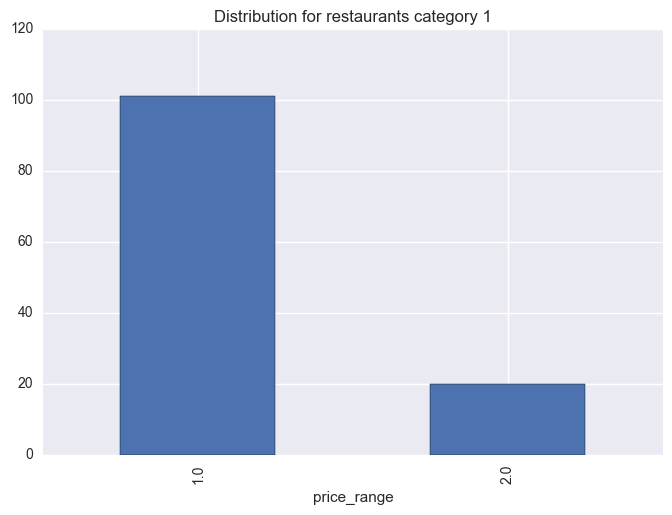

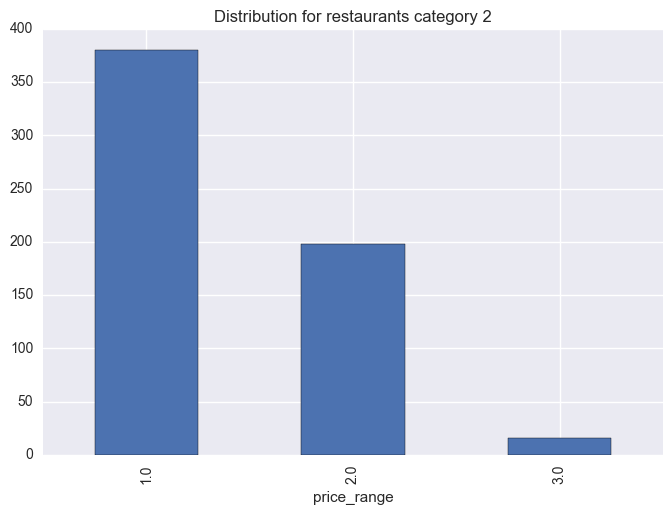

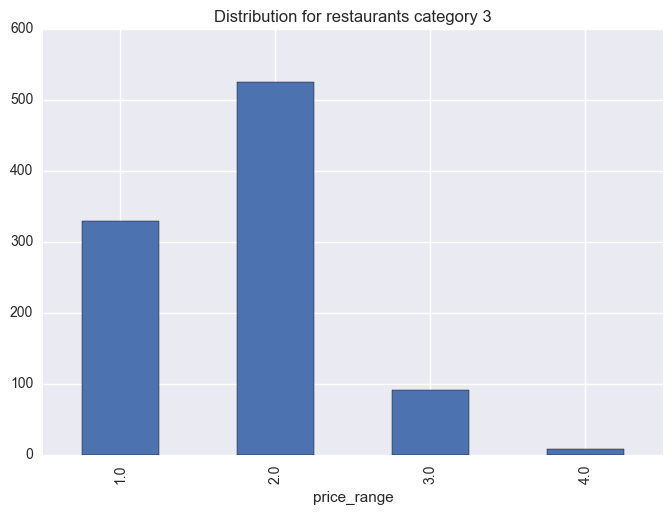

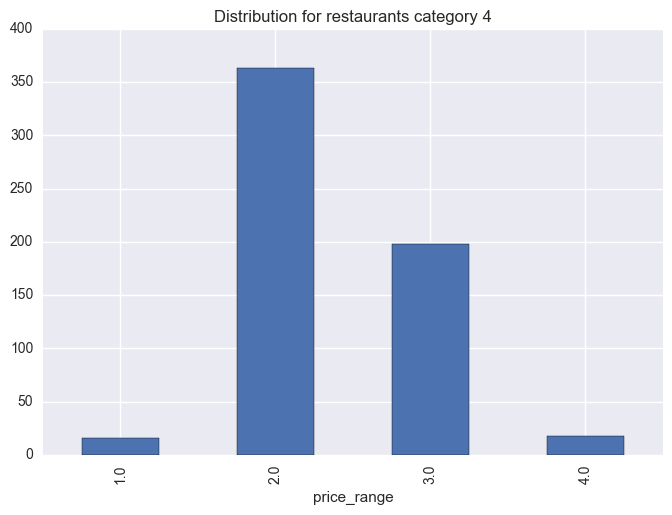

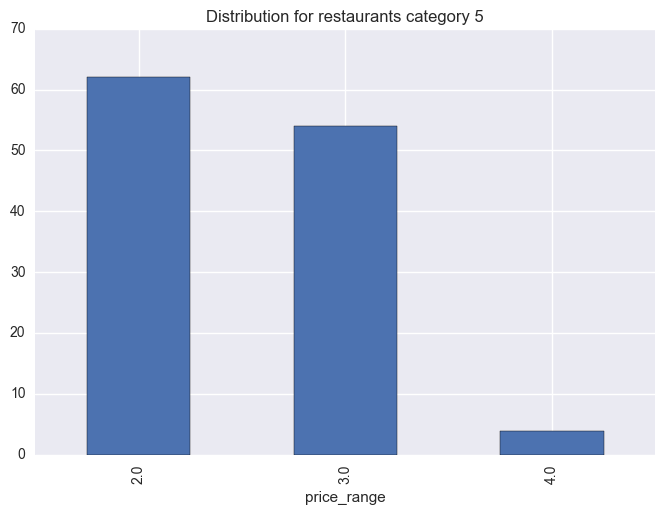

In [15]:
print "**Below is the distribution by category of success and price range**"

group_target_2=df_zomato.groupby(["target","price_range"]).size()

for i in range(1,6):
    group_target_2[i].plot(kind="bar")
    plt.title("Distribution for restaurants category %d"%i)
    plt.show()

Any price cuisine can manage to the top, however cheap places struggle to manage to make the most profit.

In [16]:
df_zomato.to_csv("zomato_with_target.csv")

____

# Fitting model of prediction

Now we have a target, let's gather all feature and link with its target

In [17]:
#starting by gathering financial and demographic features with zomato features
target=df_zomato["target"]


# taking into consideration all demographic and financial data
query='select * from "Dem_Fin_1";'
Dem_Fin=pd.read_sql(query,con=conn)
df_zomato_fin=pd.merge(df_zomato,Dem_Fin,left_on="District",right_on="Area name",how="left")


# taking into consideration 5 principal components analysis from demographic and financial data.
query='select * from "Dem_Fin_reduced";'
Dem_Fin_reduced=pd.read_sql(query,con=conn)
df_zomato_fin_reduced=pd.merge(df_zomato,Dem_Fin_reduced,left_on="District",right_on="Area name",how="left")


In [18]:
df_zomato_fin_reduced.head(2)

,id,name,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,...,location_coeff,profit_tuned,target,index,Area name,PCAf_1,PCAf_2,PCAf_3,PCAf_4,PCAf_5
0,6111707,Barracuda,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,...,1.804651,66.097128,3,8,Ealing,-1.92484,-0.182107,-0.323616,0.537674,0.340337
1,6102909,Starbucks,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,...,1.804651,22.346544,2,8,Ealing,-1.92484,-0.182107,-0.323616,0.537674,0.340337


In [19]:
col_main=[\
 'price_range',\
 'latitude',\
 'longitude',\
 'group_cuisine',\
 'area_cover',"cluster", \
 'restaurant_nearby',\
 'GLA Population Estimate 2015',\
 'GLA Household Estimate 2015',\
 'Inland Area -hec',\
 'Population density - Hec-2015',\
 'Average Age, 2015',\
 'Employment rate - 2014',\
 'Unemployment rate-2014',\
 'Gross Annual Pay-2014',\
 'Modelled Household median income estimates 2012/13',\
 'Number of jobs by workplace-2013',\
 'Jobs Density, 2013',\
 'Two-year business survival rates-2011/2015',\
 'Median House Price, 2014',\
 'Average Public Transport Accessibility score, 2014',\
 'Perc. People aged 17+ with diabetes ']

col_reduced=[
 u'price_range',
 u'latitude',
 u'longitude',
 u'group_cuisine',
 u'area_cover',
 u'restaurant_nearby',"cluster",\
 "PCAf_1",
"PCAf_2",
"PCAf_3",
"PCAf_4",
"PCAf_5"]

X_main=df_zomato_fin[col_main]

X_reduced=df_zomato_fin_reduced[col_reduced]

In [20]:
# geting dummies for type of cuisine

X_main=pd.concat([X_main,pd.get_dummies(X_main["group_cuisine"])],axis=1)
del X_main["group_cuisine"]

X_reduced=pd.concat([X_reduced,pd.get_dummies(X_reduced["group_cuisine"])],axis=1)
del X_reduced["group_cuisine"]

In [21]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler,LabelEncoder, MaxAbsScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import svm

from __future__ import division
%matplotlib inline

In [22]:
# scaling the features.
scl=StandardScaler()
X_main_scaled=scl.fit_transform(X_main)

X_reduced_scaled=scl.fit_transform(X_reduced)

In [23]:
# let's create a train and test set

X_train_main,X_test_main,y_train_main, y_test_main=train_test_split(X_main_scaled,target,test_size=0.30,random_state=73)

X_train_reduced,X_test_reduced,y_train_reduced, y_test_reduced=train_test_split(X_reduced,target,test_size=0.30,random_state=73)

On the first hand, in the following blocks I am trying diffirent classifier to get an idea of on which ones to focused on.
Later on, I will try to fit the best models with dimensionality or feature reduction.

Model I am fitting:

- Logistic regression
- Naive bays
- Support Vector Machine (classifier)
- Decision Tree (classifier)
- XGboost
- Ensemble ( Random Forest, Adaboost, Bagging, ExtraTree, Gradient Boosting)




In [25]:
print "Before starting, the repartition per category is:\n"
print df_zomato.target.value_counts()
print "Which gives us a baseline of:"
print df_zomato.target.value_counts()[3]/sum(df_zomato.target.value_counts())

Before starting, the repartition per category is:

3    953
4    595
2    594
1    121
5    120
Name: target, dtype: int64
Which gives us a baseline of:
0.399916072178


In [26]:
# I am first drawing a fonction to plot confusion matrix

import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

Logit on main set:


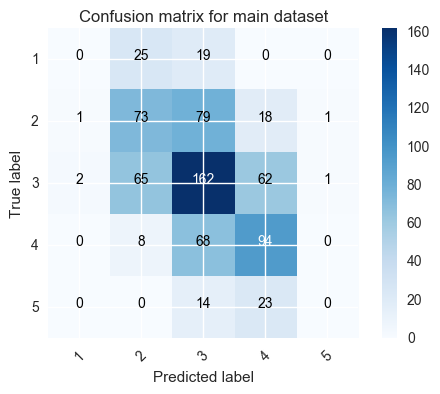

Accuracy: 0.46013986014
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.43      0.42      0.43       172
          3       0.47      0.55      0.51       292
          4       0.48      0.55      0.51       170
          5       0.00      0.00      0.00        37

avg / total       0.41      0.46      0.43       715

------

Logit on reduced set:


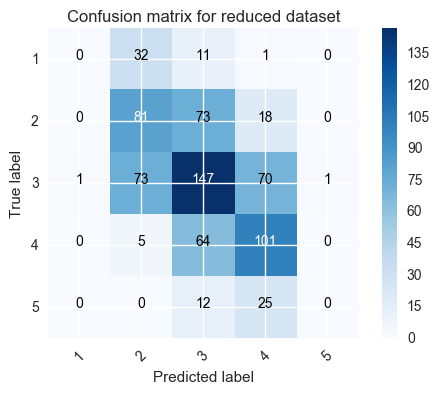

Accuracy: 0.46013986014
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.42      0.47      0.45       172
          3       0.48      0.50      0.49       292
          4       0.47      0.59      0.52       170
          5       0.00      0.00      0.00        37

avg / total       0.41      0.46      0.43       715

------



In [27]:
# Logistic regression

logit_m=LogisticRegression()
logit_m.fit(X_train_main,y_train_main)
prediction_m=logit_m.predict(X_test_main)

print "Logit on main set:"
conf_m=metrics.confusion_matrix(y_test_main,prediction_m)
plot_confusion_matrix(conf_m,classes=logit_m.classes_,title='Confusion matrix for main dataset')
print "Accuracy:",metrics.accuracy_score(y_test_main,prediction_m)
print "Classification report:\n", metrics.classification_report(y_test_main,prediction_m)
print "------\n"

logit_r=LogisticRegression()
logit_r.fit(X_train_reduced,y_train_reduced)
prediction_r=logit_r.predict(X_test_reduced)

print "Logit on reduced set:"
conf=metrics.confusion_matrix(y_test_reduced, prediction_r)
plot_confusion_matrix(conf,classes=logit_r.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_reduced, prediction_r)
print "Classification report:\n", metrics.classification_report(y_test_reduced,prediction_r)
print "------\n"


Decision Tree Classifier on main set:


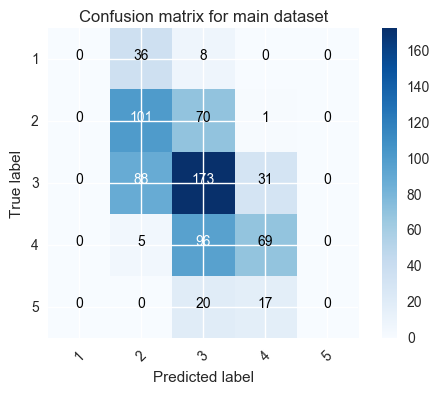

Accuracy: 0.47972027972
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.44      0.59      0.50       172
          3       0.47      0.59      0.53       292
          4       0.58      0.41      0.48       170
          5       0.00      0.00      0.00        37

avg / total       0.44      0.48      0.45       715

------

Decision Tree Classifier on reduced set:


/Users/dorian/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


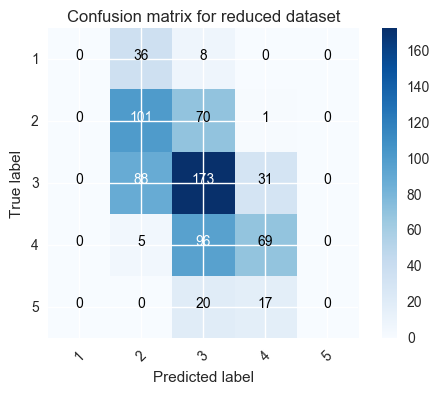

Accuracy: 0.47972027972
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.44      0.59      0.50       172
          3       0.47      0.59      0.53       292
          4       0.58      0.41      0.48       170
          5       0.00      0.00      0.00        37

avg / total       0.44      0.48      0.45       715

------



In [28]:
# Decision tree classifier

tree_m=DecisionTreeClassifier(max_depth=3, random_state=73)
tree_m.fit(X_train_main,y_train_main)
prediction_m=tree_m.predict(X_test_main)

print "Decision Tree Classifier on main set:"
conf_m=metrics.confusion_matrix(y_test_main,prediction_m)
plot_confusion_matrix(conf_m,classes=tree_m.classes_,title='Confusion matrix for main dataset')
print "Accuracy:",metrics.accuracy_score(y_test_main,prediction_m)
print "Classification report:\n", metrics.classification_report(y_test_main,prediction_m)
print "------\n"

tree_r=DecisionTreeClassifier(max_depth=3, random_state=73)
tree_r.fit(X_train_reduced,y_train_reduced)
prediction_r=tree_r.predict(X_test_reduced)

print "Decision Tree Classifier on reduced set:"
conf=metrics.confusion_matrix(y_test_reduced, prediction_r)
plot_confusion_matrix(conf,classes=tree_r.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_reduced, prediction_r)
print "Classification report:\n", metrics.classification_report(y_test_reduced,prediction_r)
print "------\n"

Naive bays on main dataset
MultinomialNB:


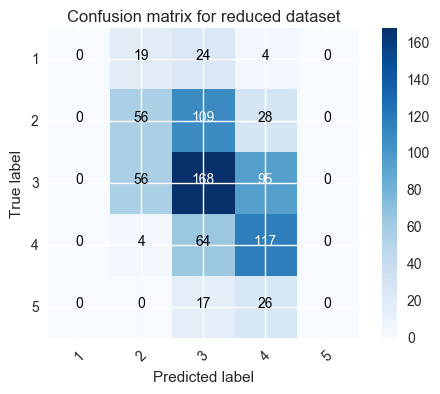

Accuracy: 0.433290978399
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        47
          2       0.41      0.29      0.34       193
          3       0.44      0.53      0.48       319
          4       0.43      0.63      0.51       185
          5       0.00      0.00      0.00        43

avg / total       0.38      0.43      0.40       787

----------------------------------

Naive bays on reduced dataset
MultinomialNB:


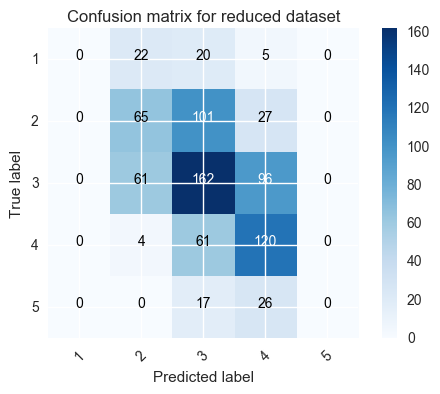

Accuracy: 0.440914866582
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        47
          2       0.43      0.34      0.38       193
          3       0.45      0.51      0.48       319
          4       0.44      0.65      0.52       185
          5       0.00      0.00      0.00        43

avg / total       0.39      0.44      0.41       787

----------------------------------



In [29]:
# Naive bays

print "Naive bays on main dataset"

Mx=MinMaxScaler()
Mx.fit(X_main)
train_main_2=pd.DataFrame(Mx.transform(X_main))
train_main_2.head()

X_train_main_2,X_test_main_2, y_train_main_2, y_test_main_2=train_test_split(train_main_2,target,test_size=0.33,random_state=73)


clf_nb=MultinomialNB()
clf_nb.fit(X_train_main_2,y_train_main_2)
prediction=clf_nb.predict(X_test_main_2)

print "MultinomialNB:"
conf=metrics.confusion_matrix(y_test_main_2, prediction)
plot_confusion_matrix(conf,classes=logit_r.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_main_2,prediction)
print "Classification report:\n", metrics.classification_report(y_test_main_2,prediction)
print "----------------------------------\n"


print "Naive bays on reduced dataset"

Mx=MinMaxScaler()
Mx.fit(X_reduced)
train_reduced_2=pd.DataFrame(Mx.transform(X_reduced))
train_reduced_2.head()

X_train_reduced_2,X_test_reduced_2, y_train_reduced_2, y_test_reduced_2=train_test_split(train_reduced_2,target,test_size=0.33,random_state=73)


clf_nb=MultinomialNB()
clf_nb.fit(X_train_reduced_2,y_train_reduced_2)
prediction=clf_nb.predict(X_test_reduced_2)

print "MultinomialNB:"
conf=metrics.confusion_matrix(y_test_reduced_2, prediction)
plot_confusion_matrix(conf,classes=logit_r.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_reduced_2,prediction)
print "Classification report:\n", metrics.classification_report(y_test_reduced_2,prediction)
print "----------------------------------\n"


SVC on main set:


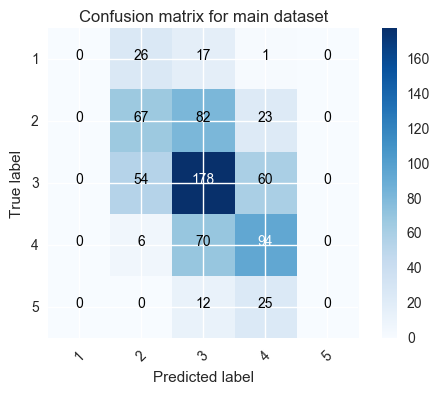

Accuracy: 0.474125874126
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.44      0.39      0.41       172
          3       0.50      0.61      0.55       292
          4       0.46      0.55      0.50       170
          5       0.00      0.00      0.00        37

avg / total       0.42      0.47      0.44       715

------

SVC on reduced set:


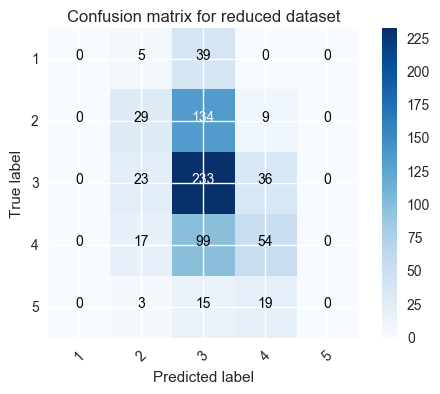

Accuracy: 0.441958041958
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.38      0.17      0.23       172
          3       0.45      0.80      0.57       292
          4       0.46      0.32      0.38       170
          5       0.00      0.00      0.00        37

avg / total       0.38      0.44      0.38       715

------



In [30]:
# Support Vector Machine classifier

SVC_m=svm.SVC()
SVC_m.fit(X_train_main,y_train_main)
prediction_m=SVC_m.predict(X_test_main)

print "SVC on main set:"
conf_m=metrics.confusion_matrix(y_test_main,prediction_m)
plot_confusion_matrix(conf_m,classes=SVC_m.classes_,title='Confusion matrix for main dataset')
print "Accuracy:",metrics.accuracy_score(y_test_main,prediction_m)
print "Classification report:\n", metrics.classification_report(y_test_main,prediction_m)
print "------\n"

SVC_r=svm.SVC()
SVC_r.fit(X_train_reduced,y_train_reduced)
prediction_r=SVC_r.predict(X_test_reduced)

print "SVC on reduced set:"
conf=metrics.confusion_matrix(y_test_reduced, prediction_r)
plot_confusion_matrix(conf,classes=SVC_r.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_reduced, prediction_r)
print "Classification report:\n", metrics.classification_report(y_test_reduced,prediction_r)
print "------\n"

xgboost on main set:


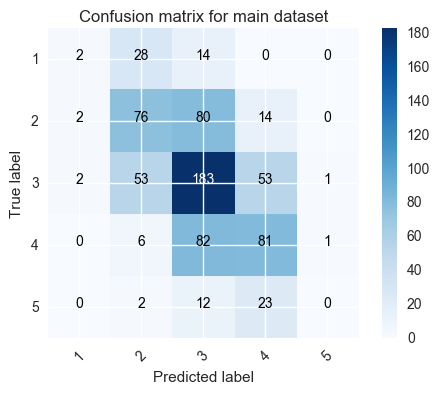

Accuracy: 0.478321678322
Classification report:
             precision    recall  f1-score   support

          1       0.33      0.05      0.08        44
          2       0.46      0.44      0.45       172
          3       0.49      0.63      0.55       292
          4       0.47      0.48      0.48       170
          5       0.00      0.00      0.00        37

avg / total       0.45      0.48      0.45       715

------

xgboost on reduced set:


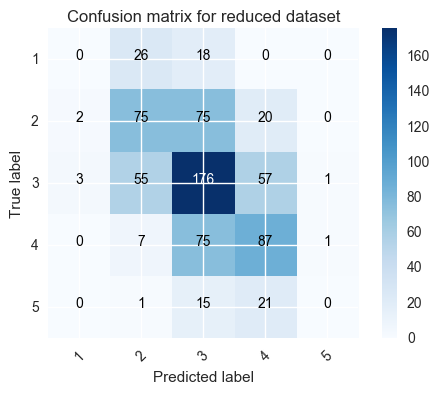

Accuracy: 0.472727272727
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.46      0.44      0.45       172
          3       0.49      0.60      0.54       292
          4       0.47      0.51      0.49       170
          5       0.00      0.00      0.00        37

avg / total       0.42      0.47      0.44       715

------



In [31]:
import xgboost

xgb_m = xgboost.XGBClassifier()
xgb_m.fit(X_train_main,y_train_main)
prediction_m=xgb_m.predict(X_test_main)

print "xgboost on main set:"
conf_m=metrics.confusion_matrix(y_test_main,prediction_m)
plot_confusion_matrix(conf_m,classes=xgb_m.classes_,title='Confusion matrix for main dataset')
print "Accuracy:",metrics.accuracy_score(y_test_main,prediction_m)
print "Classification report:\n", metrics.classification_report(y_test_main,prediction_m)
print "------\n"

xgb_r = xgboost.XGBClassifier()
xgb_r.fit(X_train_reduced,y_train_reduced)
prediction_r=xgb_r.predict(X_test_reduced)

print "xgboost on reduced set:"
conf=metrics.confusion_matrix(y_test_reduced, prediction_r)
plot_confusion_matrix(conf,classes=xgb_r.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_reduced, prediction_r)
print "Classification report:\n", metrics.classification_report(y_test_reduced,prediction_r)
print "------\n"


Fitting ensemble method to main dataset
min Bagging:0.857793558837for n-estimator:23
min Adabost:0.745109581799for n-estimator:3
min ExtraTree:0.956308212353for n-estimator:8
min RandomForest:0.876091879186for n-estimator:32
min Gradient Boosting:0.737273762832for n-estimator:16


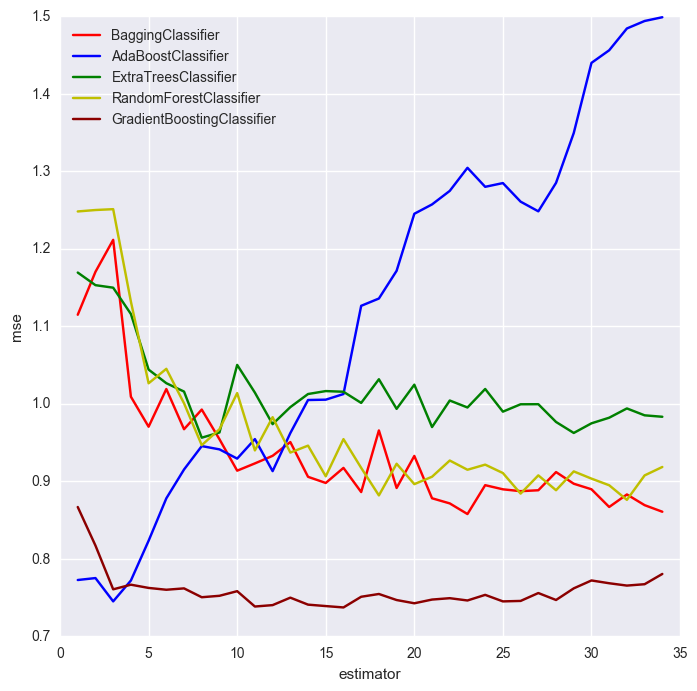

In [32]:
# Ensemble for 


print "Fitting ensemble method to main dataset"

estimators=range(1,35)

def get_mean_mse(model,n):
    ensemble=model(n_estimators=n)
    score=cross_val_score(ensemble,X_train_main,y_train_main, cv=5,scoring="neg_mean_squared_error")
    return np.mean(score)

Bagging=[]
Adaboost=[]
ExtraTree=[]
RandomForest=[]
GradientBoosting=[]


for i in estimators:
    Bagging.append(get_mean_mse(BaggingClassifier,i))
    Adaboost.append(get_mean_mse(AdaBoostClassifier,i))
    ExtraTree.append(get_mean_mse(ExtraTreesClassifier,i))
    RandomForest.append(get_mean_mse(RandomForestClassifier,i))
    GradientBoosting.append(get_mean_mse(GradientBoostingClassifier,i))

print("min Bagging:"+ str(min(np.absolute(Bagging)))+ "for n-estimator:" + \
str(estimators[Bagging.index(-min(np.absolute(Bagging)))]))

print("min Adabost:"+ str(min(np.absolute(Adaboost)))+ "for n-estimator:" + \
str(estimators[Adaboost.index(-min(np.absolute(Adaboost)))]))

print("min ExtraTree:"+ str(min(np.absolute(ExtraTree)))+ "for n-estimator:" + \
str(estimators[ExtraTree.index(-min(np.absolute(ExtraTree)))]))

print("min RandomForest:"+ str(min(np.absolute(RandomForest)))+ "for n-estimator:" + \
str(estimators[RandomForest.index(-min(np.absolute(RandomForest)))]))

print("min Gradient Boosting:"+ str(min(np.absolute(GradientBoosting)))+ "for n-estimator:" + \
str(estimators[GradientBoosting.index(-min(np.absolute(GradientBoosting)))]))

plt.figure(figsize=(8,8))
plt.plot(estimators,np.absolute(Bagging),label="BaggingClassifier",c="r")
plt.plot(estimators,np.absolute(Adaboost),label="AdaBoostClassifier",c="b")
plt.plot(estimators,np.absolute(ExtraTree),label="ExtraTreesClassifier",c="g")
plt.plot(estimators,np.absolute(RandomForest),label="RandomForestClassifier",c="y")
plt.plot(estimators,np.absolute(GradientBoosting),label="GradientBoostingClassifier",c="Darkred")
plt.xlabel("estimator")
plt.ylabel("mse")
plt.legend(loc=2)
plt.show()

Fitting ensemble method to reduced dataset
min Bagging:0.86675792376for n-estimator:28
min Adabost:0.678544637066for n-estimator:2
min ExtraTree:0.937670792276for n-estimator:32
min RandomForest:0.846477216613for n-estimator:28
min Gradient Boosting:0.754610743055for n-estimator:9


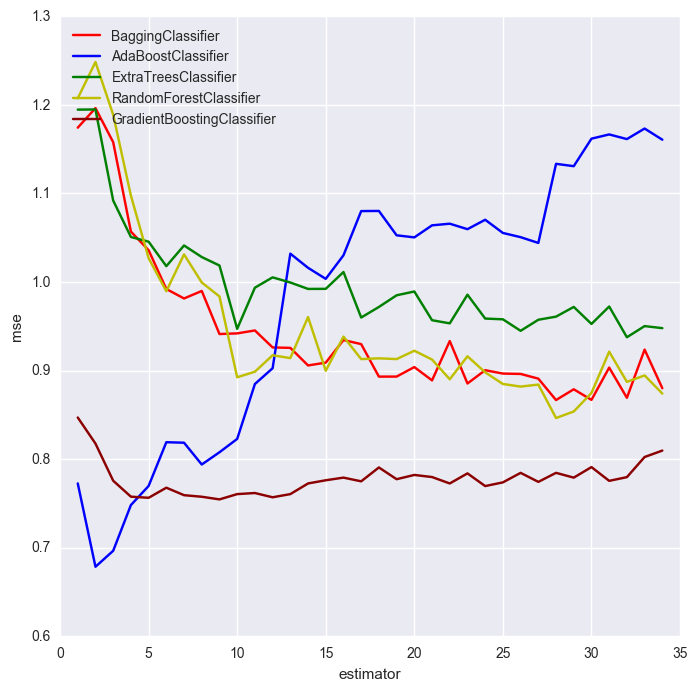

In [33]:
# Ensemble for reduced set


print "Fitting ensemble method to reduced dataset"

estimators=range(1,35)

def get_mean_mse(model,n):
    ensemble=model(n_estimators=n)
    score=cross_val_score(ensemble,X_train_reduced,y_train_reduced, cv=5,scoring="neg_mean_squared_error")
    return np.mean(score)

Bagging=[]
Adaboost=[]
ExtraTree=[]
RandomForest=[]
GradientBoosting=[]

for i in estimators:
    Bagging.append(get_mean_mse(BaggingClassifier,i))
    Adaboost.append(get_mean_mse(AdaBoostClassifier,i))
    ExtraTree.append(get_mean_mse(ExtraTreesClassifier,i))
    RandomForest.append(get_mean_mse(RandomForestClassifier,i))
    GradientBoosting.append(get_mean_mse(GradientBoostingClassifier,i))
    
print("min Bagging:"+ str(min(np.absolute(Bagging)))+ "for n-estimator:" + \
str(estimators[Bagging.index(-min(np.absolute(Bagging)))]))

print("min Adabost:"+ str(min(np.absolute(Adaboost)))+ "for n-estimator:" + \
str(estimators[Adaboost.index(-min(np.absolute(Adaboost)))]))

print("min ExtraTree:"+ str(min(np.absolute(ExtraTree)))+ "for n-estimator:" + \
str(estimators[ExtraTree.index(-min(np.absolute(ExtraTree)))]))

print("min RandomForest:"+ str(min(np.absolute(RandomForest)))+ "for n-estimator:" + \
str(estimators[RandomForest.index(-min(np.absolute(RandomForest)))]))

print("min Gradient Boosting:"+ str(min(np.absolute(GradientBoosting)))+ "for n-estimator:" + \
str(estimators[GradientBoosting.index(-min(np.absolute(GradientBoosting)))]))

plt.figure(figsize=(8,8))
plt.plot(estimators,np.absolute(Bagging),label="BaggingClassifier",c="r")
plt.plot(estimators,np.absolute(Adaboost),label="AdaBoostClassifier",c="b")
plt.plot(estimators,np.absolute(ExtraTree),label="ExtraTreesClassifier",c="g")
plt.plot(estimators,np.absolute(RandomForest),label="RandomForestClassifier",c="y")
plt.plot(estimators,np.absolute(GradientBoosting),label="GradientBoostingClassifier",c="Darkred")
plt.xlabel("estimator")
plt.ylabel("mse")
plt.legend(loc=2)
plt.show()

GradientBoostingClassifier for main set


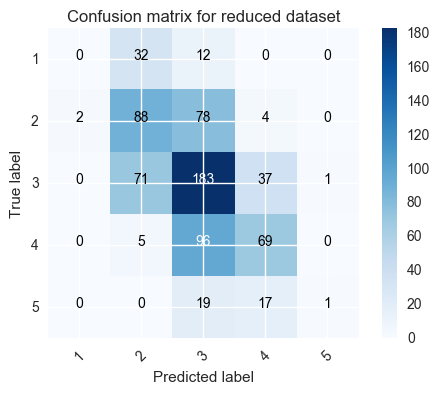

Accuracy: 0.476923076923
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.45      0.51      0.48       172
          3       0.47      0.63      0.54       292
          4       0.54      0.41      0.46       170
          5       0.50      0.03      0.05        37

avg / total       0.46      0.48      0.45       715

------



In [35]:
print "GradientBoostingClassifier for main set"

ad = GradientBoostingClassifier(n_estimators=16,random_state=73)

model_m=ad.fit(X_train_main,y_train_main)
prediction=model_m.predict(X_test_main)


conf=metrics.confusion_matrix(y_test_main, prediction)
plot_confusion_matrix(conf,classes=model_m.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_main, prediction)
print "Classification report:\n", metrics.classification_report(y_test_main,prediction)
print "------\n"





GradientBoostingClassifier for reduced set


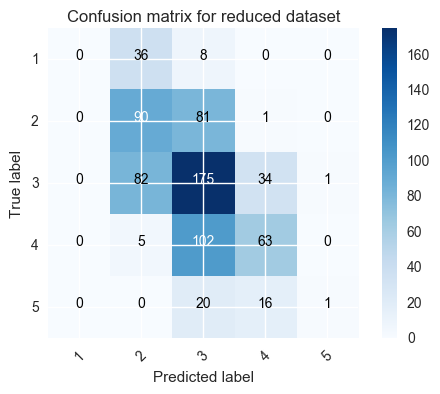

Accuracy: 0.46013986014
Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        44
          2       0.42      0.52      0.47       172
          3       0.45      0.60      0.52       292
          4       0.55      0.37      0.44       170
          5       0.50      0.03      0.05        37

avg / total       0.44      0.46      0.43       715

------

accuracity: 0.46013986014


In [36]:
print "GradientBoostingClassifier for reduced set"

ad = GradientBoostingClassifier(n_estimators=5,random_state=73)

model_r=ad.fit(X_train_reduced,y_train_reduced)
prediction=model_r.predict(X_test_reduced)

conf=metrics.confusion_matrix(y_test_reduced, prediction)
plot_confusion_matrix(conf,classes=model_r.classes_,title='Confusion matrix for reduced dataset')
print "Accuracy:",metrics.accuracy_score(y_test_reduced, prediction)
print "Classification report:\n", metrics.classification_report(y_test_reduced,prediction)
print "------\n"

print "accuracity:", metrics.accuracy_score(y_test_reduced,prediction)


## Summary

From this first round of test fitting, we have manage to get an accuracy of 0.47 with Support Vector Classihier ,Xgboost and GradientBoostClassifier. Other gave the same accuracy but only manage to detect 2 categories.

Even though we are above the baseline by 8%, we are still far for having an interesting model for a business perspective.
Next steps are:
- Optimising Demographic and Financial features. Indeed, each restaurant get the financial and demographic data of the district is in event hough it should be proportional to the distance to each district.
- Carrying out dimensionality and feature reduction and see if we can avoid some overfitting.
- For each restaurant, make compete classifiers between them and select the most frequent output category.
- Search for the best parameters for selected classifiers
- Getting TripAdvisor restaurants information to confirm the "profit model" data and apply to a more updated database. As reminder, we have the limitation that Zomato does not have as many restaurants registered as TripAdvisor has. Also it seems Londoner used TripAdvisor in a frequent basis compared to Zomato which will enable to check the validity of my categorisation model based on my "expected profit" formula by getting the TripAdvisor reviews overtime.


In [39]:
# saving to csv train_test set and target

df_zomato_fin.to_csv("train_test_zomato.csv")

target.to_csv("target_zomato.csv")